In [11]:
from pathlib import Path
import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import pyedflib
from mne.time_frequency import psd_array_welch
from IPython.display import display
from scipy.signal import csd, welch, coherence


In [38]:
data = Path(r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\rbd1.edf")
raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
raw.load_data()
raw.info["sfreq"], len(raw.ch_names), raw.ch_names[:10]
eeg_chs = ["Fp2-F4", "F4-C4", "C4-P4", "P4-O2", "C4-A1", "F8-T4", "F7-T3"]
ecg_chs  = ["ECG1-ECG2"]
resp_chs = ["TORACE", "ADDOME"]
eog_chs  = ["ROC-LOC"]
raw.get_channel_types(picks=eeg_chs[:5] + ecg_chs + resp_chs)
print("Sampling frequency:", raw.info["sfreq"])
print("Duration (s):", raw.n_times / raw.info["sfreq"])

Reading 0 ... 15498751  =      0.000 ... 30270.998 secs...


C:\Users\carlo\AppData\Local\Temp\ipykernel_29580\3843718550.py:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_29580\3843718550.py:2: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_29580\3843718550.py:2: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)


Sampling frequency: 512.0
Duration (s): 30271.0


In [39]:
txt_path = r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\rbd1.txt"
df = pd.read_csv(txt_path, sep='\t', header=None, names=["Sleep Stage", "Position", "Time [hh:mm:ss]", "Event", "Duration[s]", "Location"], skiprows=22)
df.head()

,Sleep Stage,Position,Time [hh:mm:ss],Event,Duration[s],Location
0,W,Unknown Position,23:07:19,SLEEP-S0,30,ROC-LOC
1,W,Unknown Position,23:07:49,SLEEP-S0,30,ROC-LOC
2,W,Unknown Position,23:08:19,SLEEP-S0,30,ROC-LOC
3,W,Unknown Position,23:08:49,SLEEP-S0,30,ROC-LOC
4,W,Unknown Position,23:09:19,SLEEP-S0,30,ROC-LOC


In [40]:
epoch_len = 30.0
df["onset_s"] = np.arange(len(df)) * epoch_len

# WAKE EPOCHS
wake = df[df["Sleep Stage"] == "W"]
wake = df[df["Sleep Stage"] == "W"].copy()
wake_epochs = list(zip(wake["onset_s"].to_numpy(), (wake["onset_s"] + wake["Duration[s]"]).to_numpy()))
t0_wake, t1_wake = wake_epochs[0]
dur_wake = float(t1_wake - t0_wake)
t0_wake, t1_wake, dur_wake

# REM EPOCHS
rem = df[df["Sleep Stage"] == "R"]
rem = df[df["Sleep Stage"] == "R"].copy()
rem_epochs = list(zip(rem["onset_s"].to_numpy(), (rem["onset_s"] + rem["Duration[s]"]).to_numpy()))
t0_rem, t1_rem = rem_epochs[0]
dur_rem = float(t1_rem - t0_rem)
t0_rem, t1_rem, dur_rem

#S1 EPOCHS
S1 = df[df["Sleep Stage"] == "S1"]
S1 = df[df["Sleep Stage"] == "S1"].copy()
S1_epochs = list(zip(S1["onset_s"].to_numpy(), (S1["onset_s"] + S1["Duration[s]"]).to_numpy()))
t0_S1, t1_S1 = S1_epochs[0]
dur_S1 = float(t1_S1 - t0_S1)
t0_S1, t1_S1, dur_S1

# S2 EPOCHS
S2 = df[df["Sleep Stage"] == "S2"]
S2 = df[df["Sleep Stage"] == "S2"].copy()
S2_epochs = list(zip(S2["onset_s"].to_numpy(), (S2["onset_s"] + S2["Duration[s]"]).to_numpy()))
t0_S2, t1_S2 = S2_epochs[0]
dur_S2 = float(t1_S2 - t0_S2)
t0_S2, t1_S2, dur_S2

# S3 EPOCHS
S3 = df[df["Sleep Stage"] == "S3"]
S3 = df[df["Sleep Stage"] == "S3"].copy()
S3_epochs = list(zip(S3["onset_s"].to_numpy(), (S3["onset_s"] + S3["Duration[s]"]).to_numpy()))
t0_S3, t1_S3 = S3_epochs[0]
dur_S3 = float(t1_S3 - t0_S3)
t0_S3, t1_S3, dur_S3

# S4 EPOCHS
S4 = df[df["Sleep Stage"] == "S4"]
S4 = df[df["Sleep Stage"] == "S4"].copy()
S4_epochs = list(zip(S4["onset_s"].to_numpy(), (S4["onset_s"] + S4["Duration[s]"]).to_numpy()))
t0_S4, t1_S4 = S4_epochs[0]
dur_S4 = float(t1_S4 - t0_S4)
t0_S4, t1_S4, dur_S4

(np.float64(1890.0), np.float64(1920.0), 30.0)

Creating RawArray with float64 data, n_channels=1, n_times=15498752
    Range : 0 ... 15498751 =      0.000 ... 30270.998 secs
Ready.


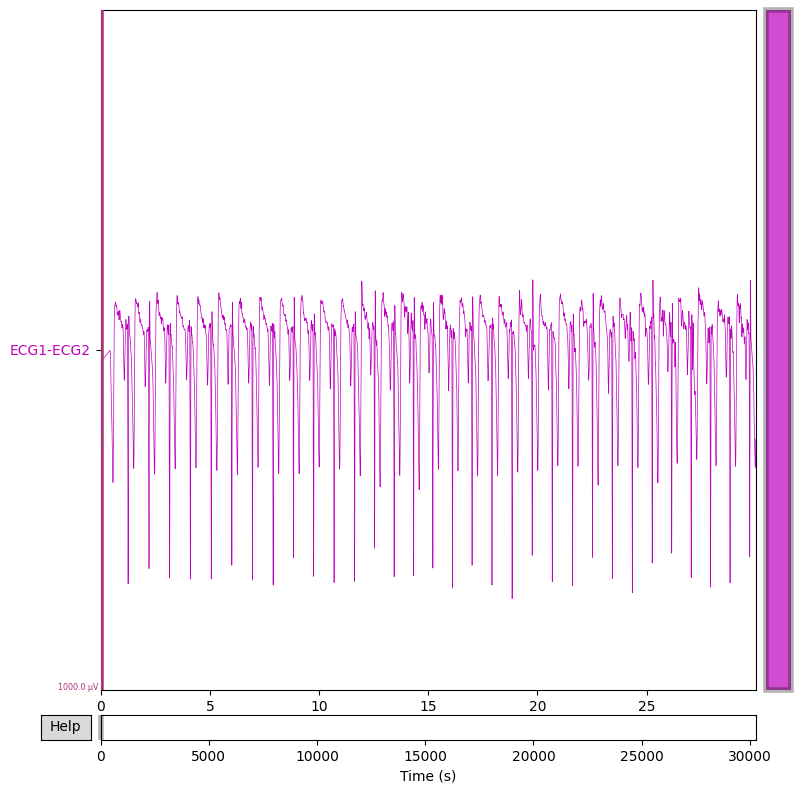

In [41]:
# Raw ECG in Rem Sleep 
sf = raw.info["sfreq"]
ecg_1d = raw.copy().pick(ecg_chs).load_data().get_data()[0]
a, b = int(t0_rem*sf), int(t1_rem*sf)
ecg_seg = ecg_1d[a:b]

# Filter ECG 
ecg_data = raw.copy().pick(ecg_chs).load_data().get_data()[0]
ecg_filtered = nk.ecg_clean(ecg_data, sampling_rate=raw.info["sfreq"], method="neurokit", lowcut=0.5, highcut=45)
# Create a new Raw object for plotting
info = mne.create_info(ch_names=ecg_chs, sfreq=raw.info["sfreq"], ch_types=['ecg'])
ecg_filtered_raw = mne.io.RawArray(ecg_filtered.reshape(1, -1), info)
fig = ecg_filtered_raw.plot(start=0, duration=dur_rem, scalings=dict(eeg=30e-6), title="ECG — FILTERED", show=True)

ecg_ch = ecg_chs[0]  

ecg_sig_total = raw.copy().pick([ecg_ch]).load_data().get_data()[0]
ecg_clean_total = nk.ecg_clean(ecg_sig_total, sampling_rate=sf, method="neurokit")


In [42]:
resp = raw.copy().pick(["TORACE"]).load_data().get_data()[0]

def hpc_metric(ecg, resp, epochs, sf):
    rows = []
    fs_cpc = 4  # Resample ECG and Resp to a common frequency for coherence analysis
    for i, (t0, t1) in enumerate(epochs):
        a, b = int(t0*sf), int(t1*sf)
        x_ecg = ecg[a:b]
        x_resp = resp[a:b]
        try:
             _, info = nk.ecg_peaks(x_ecg, sampling_rate=sf)
             rpeaks = info["ECG_R_Peaks"]
             rr = np.diff(rpeaks) / sf  # RR intervals in seconds
             t_rr = np.cumsum(rr)  # Time points of RR intervals
             t_grid = np.arange(t_rr[0], t_rr[-1], 1/fs_cpc)
             rr_resampled = np.interp(t_grid, t_rr, rr)  # Resample RR intervals to common grid
             t_resp_grid = np.arange(len(x_resp))/sf
             x_resp_resampled = np.interp(t_grid, t_resp_grid, x_resp)  # Resample Resp to common grid
             nps = min(256, len(rr_resampled))
             f, Cxy = coherence(rr_resampled, x_resp_resampled, fs=fs_cpc, nperseg=nps)
             f2, Pxy = csd(rr_resampled, x_resp_resampled, fs=fs_cpc, nperseg=nps)

             cpc_spec = np.abs(Pxy) * Cxy
             lf_mask = (f >= 0.01) & (f < 0.15)
             hf_mask = (f >= 0.15) & (f <= 0.40)
             HFC = np.trapezoid(cpc_spec[hf_mask], f[hf_mask])
             LFC = np.trapezoid(cpc_spec[lf_mask], f[lf_mask])
             LFC_HFC_ratio = LFC / HFC if HFC > 0 else np.nan
             rows.append({"epoch": i, "HFC": HFC, "LFC": LFC, "LFC/HFC": LFC_HFC_ratio, "ok": True})
        except Exception as e:
             rows.append({"epoch": i, "start_s": float(t0), "ok": False, "error": str(e)})
             continue   

    return pd.DataFrame(rows)

In [43]:
def make_cpc_epochs(total_seconds, win_s=512, step_s=128, start_s=0):
    """
    Canonical CPC-ish: 512s window (~8.5 min), 128s step (~2.1 min)
    Returns list of (t0, t1) in seconds.
    """
    epochs = []
    t = start_s
    while t + win_s <= total_seconds:
        epochs.append((t, t + win_s))
        t += step_s
    return epochs

In [44]:
total_seconds = len(ecg_data) / sf   # ecg e resp têm de ter mesmo length
epochs_cpc = make_cpc_epochs(total_seconds, win_s=512, step_s=128)

df_cpc = hpc_metric(ecg_data, resp, epochs_cpc, sf)
df_cpc.head()


,epoch,HFC,LFC,LFC/HFC,ok
0,0,0.000005,3.110774e-06,0.650870,True
1,1,0.000005,3.784404e-06,0.733519,True
2,2,0.000003,1.466343e-05,4.521188,True
3,3,0.000002,5.675662e-07,0.351352,True
4,4,0.000011,3.518282e-07,0.033421,True


In [45]:
df_ok = df_cpc[df_cpc["ok"] == True].copy()

df_ok["state"] = np.where(df_ok["LFC/HFC"] < 1, "stable", "unstable")

stable_pct = 100 * (df_ok["state"] == "stable").mean()
unstable_pct = 100 * (df_ok["state"] == "unstable").mean()

stable_pct, unstable_pct


(np.float64(77.25321888412017), np.float64(22.746781115879827))

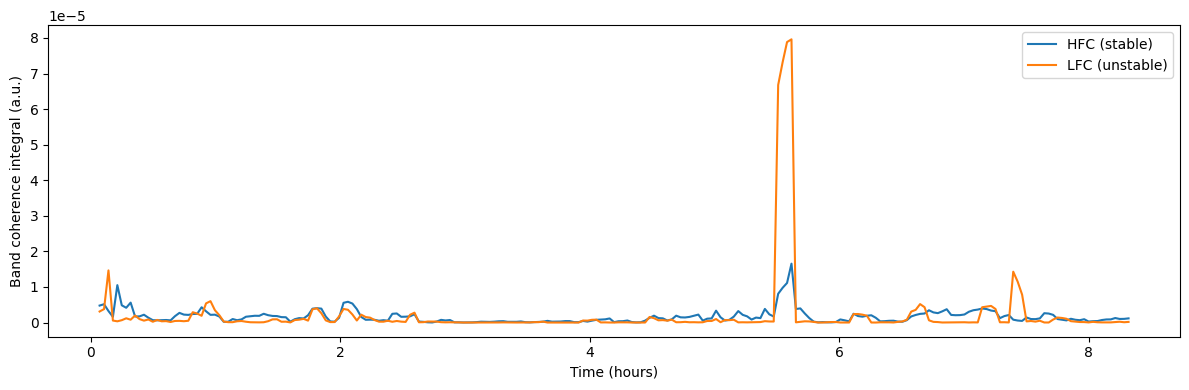

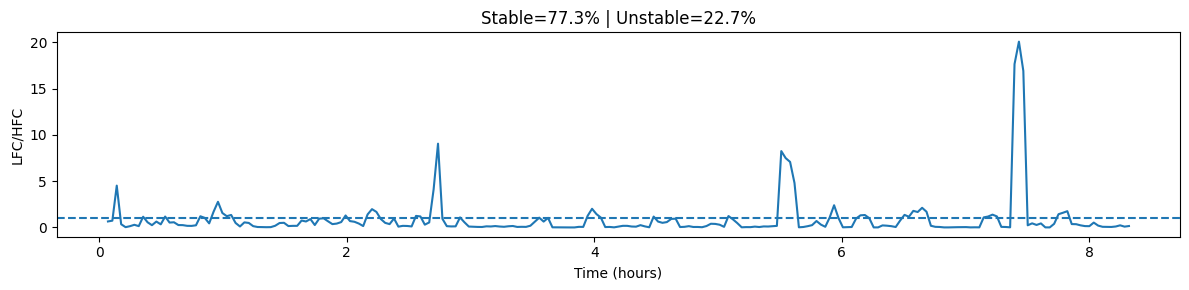

: 

In [ ]:
t_center = np.array([ (t0+t1)/2 for (t0,t1) in epochs_cpc[:len(df_ok)] ]) / 3600.0

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(t_center, df_ok["HFC"], label="HFC (stable)")
plt.plot(t_center, df_ok["LFC"], label="LFC (unstable)")
plt.xlabel("Time (hours)")
plt.ylabel("Band coherence integral (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(t_center, df_ok["LFC/HFC"])
plt.axhline(1.0, linestyle="--")
plt.xlabel("Time (hours)")
plt.ylabel("LFC/HFC")
plt.title(f"Stable={stable_pct:.1f}% | Unstable={unstable_pct:.1f}%")
plt.tight_layout()
plt.show()
